https://archive.ics.uci.edu/dataset/462/drug+review+dataset+drugs+com

# Flatiron Phase 5 Project

## Aaron Galbraith

https://www.linkedin.com/in/aarongalbraith \
https://github.com/aarongalbraith

### Submitted: November 21, 2023

## working contents

- **[functions](#functions)<br>**
- **[rough overview](#rough-overview)<br>**
- **[missing values](#missing-values)<br>**
- **[duplicates](#duplicates)<br>**
- **[brand / generic pairs](#brand-/-generic-pairs)<br>**
- **[further exploration of duplicates (skip for now)](#further-exploration-of-duplicates-(skip-for-now))<br>**
- **[contractions](#contractions)<br>**
- **[dates](#dates)<br>**
- **[ratings](#ratings)<br>**
- **[focusing on birth control](#focusing-on-birth-control)<br>**
- **[save and reload preprocessed set](#save-and-reload-preprocessed-set)<br>**
- **[feature engineering ideas](#feature-engineering-ideas)<br>**
- **[rudimentary word cloud maker](#rudimentary-word-cloud-maker)<br>**
- **[end](#end)<br>**


## Contents

- **[Business Understanding](#Business-Understanding)<br>**
- **[Data Understanding](#Data-Understanding)**<br>
- **[Data Preparation](#Data-Preparation)**<br>
- **[Exploration](#Exploration)**<br>
- **[Modeling](#Modeling)**<br>
- **[Evaluation](#Evaluation)**<br>
- **[Recommendations](#Recommendations)<br>**
- **[Further Inquiry](#Further-Inquiry)**<br>

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import FreqDist
from nltk.corpus import stopwords
import string
from wordcloud import WordCloud

import html
import contractions

import re

from IPython.display import display

from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score, precision_score, f1_score
from sklearn.pipeline import Pipeline

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, GridSearchCV

from pathlib import Path

SEED = 1979

do_grids = True

In [ ]:
d1 = pd.read_csv('../data/drugsComTrain_raw.tsv', delimiter='\t', encoding='latin-1')
d2 = pd.read_csv('../data/drugsComTest_raw.tsv', delimiter='\t', encoding='latin-1')
df = pd.concat([d1,d2]).reset_index().drop(columns=['Unnamed: 0', 'index'])

# functions

In [3]:
def show_review(index):
    print(df.review.loc[index])
    display(df[df.review == df.loc[index].review][['drugName', 'condition', 'rating', 'date', 'usefulCount']])

In [19]:
# a function that generates a word cloud of a given list of words
def make_wordcloud(wordlist, colormap='Greens', title=None):
    # instantiate wordcloud
    wordcloud = WordCloud(
        width=600,
        height=400,
        colormap=colormap,
        collocations = True
    )
    return wordcloud.generate(','.join(wordlist))

In [ ]:
# a function that plots the word cloud
def plot_wordcloud(wordcloud):
    # plot wordcloud
    plt.figure(figsize = (12, 15)) 
    plt.imshow(wordcloud) 
    plt.axis('off');

In [82]:
def plot_useful(feature, low=0.15, high=0.85):
    X = range(int(df[feature].quantile(low)), int(df[feature].quantile(high)))
    Y = []
    for x in X:
        Y.append(df[df[feature] == x].usefulCount.mean())
    fig, ax = plt.subplots()
    ax.plot(X,Y);

# rough overview

In [ ]:
df.head()

In [ ]:
df.shape

In [ ]:
df.info()

There are some missing condition labels.

In [ ]:
df.drugName.value_counts()

In [ ]:
df.drugName.value_counts().quantile(.90)

There are 3,671 unique drug names, and 10% of the drug names have more than 120 reviews.

In [ ]:
df.condition.value_counts()

In [ ]:
df.condition.value_counts().quantile(.90)

There are 916 unique conditionis, and 10% of the conditions have more than 332 reviews.

In [ ]:
df.rating.value_counts()

In [ ]:
df.rating.hist(bins=10);

Most of the conditions lie at the extremes, and more of them appear to be at the positive extreme.

In [ ]:
df.groupby('drugName').condition.nunique().value_counts()

This means that, for example, 1869 drugs treat 1 condition only, etc.

In [ ]:
df.groupby('condition').drugName.nunique().value_counts()

This means that 188 conditions are treatable by two drugs, etc.

In [ ]:
pd.set_option("display.max_rows", None)
print(df.drugName.value_counts())
pd.set_option("display.max_rows", 10)

A casual overview of the drug names indicates that they all seem valid. Some seem to specify drug combinations and/or dosage amounts.

In [ ]:
pd.set_option("display.max_rows", None)
print(df.condition.value_counts())
pd.set_option("display.max_rows", 10)

Oddly, the condition labels often (always?) omit initial 'F' and terminal 'r'. We can isolate instances of the former by searching for conditions that start with a lower case letter.

We will eventually trim our records to a number of conditions that Planned Parenthood specializes in treating, but we will need all the records to help us determine missing condition labels. After we have restored (or discarded) all missing condition labels, we can drop the conditions outside the scope of this review.

## dates

(Do this date analysis *after* we have trimmed to just the records we'll use?)

There's probably a datetime method for this, but the following will produce month // day // year, and then we can figure out the earliest and latest dates.

In [ ]:
df['month'] = df.date.apply(lambda x: re.split(r'\W+', x)[0])
df['day'] = df.date.apply(lambda x: int(re.split(r'\W+', x)[1]))
df['year'] = df.date.apply(lambda x: int(re.split(r'\W+', x)[2]))

In [ ]:
df.year.min()

In [ ]:
df[df.year == 2008].month.value_counts()

In [ ]:
df[(df.year == 2008) &
   (df.month == 'February')
  ].day.min()

In [ ]:
df.year.max()

In [ ]:
df[df.year == 2017].month.value_counts()

In [ ]:
df[(df.year == 2017) &
   (df.month == 'December')
  ].day.max()

The reviews span from February 24, 2008 to December 12, 2017.

In [ ]:
df.year.hist();

## review text

In [ ]:
for i in range(10):
    print(df.review[i], '\n-----')

# language cleaning

Before we go any further, we would like to clean up some of the review text. In particular, there are many escaped characters, especially apostrophes.

Here is an example of a contraction.

In [ ]:
df.review[3][56:69]

Here is how the html function fixes it.

In [ ]:
html.unescape(df.loc[3][2])[56:64]

Here is how the contractions function fixes (the html function's fix of) it.

In [ ]:
contractions.fix(html.unescape(df.loc[3][2]))[56:65]

Here is an instance of "ain't" with the same functions applied.

In [ ]:
df.review.loc[507][75:99]

In [ ]:
html.unescape(df.review.loc[507])[75:94]

In [ ]:
contractions.fix(html.unescape(df.review.loc[507]))[75:96]

In [ ]:
len(df[df.review.str.contains('ain&#039;t')])

There are 53 instances of "ain't".

I'm currently having difficulty downloading the package that appropriately fixes "ain't" into "is not" or "are not" etc. This shouldn't matter after I remove stop words. I think it will be helpful to exclude negatives like "no" and "not" from the stop words. It could certainly be of help to look for bigrams like "not good".

In [ ]:
df.review = df.review.apply(lambda x: contractions.fix(html.unescape(x)))

# missing values

In [ ]:
len(df[df.condition.isna()])

In [ ]:
df.condition.fillna('missing', inplace=True)

In [ ]:
len(df[df.condition == 'missing'])

We noticed another condition label that was meant to indicate missing and should be accordingly changed.

In [ ]:
df.condition = df.condition.apply(lambda x: 'missing' if 'Not Listed' in x else x)

In [ ]:
len(df[df.condition == 'missing'])

We've identified some actual missing condition labels, but we noticed there are more condition labels that seem suspicious, particularly ones that start with something other than an upper case character. Let's look at all such condition labels.

In [ ]:
set(df[(~df.condition.str[0].isin(list(string.ascii_uppercase))) &
   (df.condition != 'missing')
  ].condition)

These fall into three categories. Ones that include "users found this comment helpful" should be regarded as erroneous and therefore missing.

In [ ]:
df.condition = df.condition.apply(lambda x: 'missing' if 'users found' in x else x)

In [ ]:
len(df[df.condition == 'missing'])

Ones that show a clipped copy of the drug name label and end with a parenthesis should also be regarded as missing.

In [ ]:
df.condition = df.condition.apply(lambda x: 'missing' \
                                  if x[0] not in list(string.ascii_uppercase) and \
                                  x[-1] in ['(', ')'] \
                                  else x)

In [ ]:
len(df[df.condition == 'missing'])

# restoring erroneous condition labels

(skip this step because we're just focusing on birth control?)

Most of the ones that show a clipped version of the condition label can possibly be restored.

In [ ]:
def condition_restore(condition):
    if condition.split()[-1] in ['Disorde', 'eve', 'Shoulde', 'Cance']:
        condition = condition+'r'
    if condition.split()[0] in ['acial', 'ibrocystic', 'ungal', 'amilial', 'ailure', 'ever', \
                                'emale', 'unctional', 'actor', 'ibromyalgia', 'atigue']:
        condition = 'F'+condition
    if condition.split()[0] in ['llicular', 'llicle', 'lic', 'cal']:
        condition = 'Fo'+condition
    if condition.split()[0] in ['mance']:
        condition = 'Perfor'+condition
    if condition.split()[0] in ['zen']:
        condition = 'Fro'+condition
    if condition.split()[0] in ['mis']:
        condition = 'Dermatitis Herpetifor'+condition
    return condition

df.condition = df.condition.apply(lambda x: condition_restore(x))

Let's look at what we have left.

In [ ]:
set(df[(~df.condition.str[0].isin(list(string.ascii_uppercase))) &
   (df.condition != 'missing')
  ].condition)

"von Willebrand's Disease" appears to be a naturally uncapitalized condition. The others have been impossible to restore and will also be regarded as missing.

In [ ]:
df.condition = df.condition.apply(lambda x: 'missing' \
                                  if x[0] not in list(string.ascii_uppercase) and \
                                  x.split()[0] != 'von' \
                                  else x)

In [ ]:
len(df[df.condition == 'missing'])

We will be able to restore more of these missing condition labels after we do some work with duplicates.

# duplicates

In [ ]:
df.duplicated().value_counts()

In [ ]:
df[df.duplicated()]

In [ ]:
show_review(178703)

This is curious. The same review is recorded four times. There are two identical pairs, where the difference between the pairs is the drug name. We can drop one from each pair, but the pairs themselves will need to be revisited.

In [ ]:
df.drop_duplicates(inplace=True)

# brand / generic pairs

The main type of duplicate we should look out for is records with duplicate reviews, as those likely indicate some kind of actual erroneous duplication. Let's see how many of those there are.

In [ ]:
df.duplicated(subset=['review']).value_counts()

That's a lot!

Let's explore some facets of these duplicates.

In [ ]:
len(df[df.duplicated(subset=df.columns.difference(['drugName']))])

The vast majority of duplicate reviews are accounted for by different drug names. Let's explore some examples.

In [ ]:
df[df.duplicated(subset=df.columns.difference(['drugName']))].head()

In [ ]:
show_review(524)

In [ ]:
show_review(574)

In [ ]:
show_review(726)

In [ ]:
show_review(1070)

In [ ]:
show_review(1375)

These five examples make clear that the vast majority of duplicates are due to double-entry; (nearly) every review is entered once with its generic name and once with its brand name.

We can use this phenomenon to restore some of the missing condition labels. If a missing condition label is part of such a unique pair, then we can confidently assign it the condition of its pair-mate.

Let's broaden our search to records that duplicate every feature other than drug name and condition.

In [ ]:
len(df[df.duplicated(subset=df.columns.difference(['drugName', 'condition']))])

This is how many records are duplicates of other records in all values EXCEPT (POSSIBLY) drug name and condition. If a record is duplicated in this manner, the second (and third, fourth, etc.) instance will be captured in this bucket of dupes.

If we check only this bucket for dupes, we can see whether there are any triplets, etc.

In [ ]:
df_dupes = df[df.duplicated(subset=df.columns.difference(['drugName', 'condition']))]

In [ ]:
len(df_dupes[df_dupes.duplicated(subset=df_dupes.columns.difference(['drugName', 'condition']))])

There is only one.

In [ ]:
df_dupes[df_dupes.duplicated(subset=df_dupes.columns.difference(['drugName', 'condition']))]

In [ ]:
show_review(140144)

There are 6 records with the same review, date, rating, and condition. (The reviews on October 5, 2012, appear to be just a coincidence of the same review wording.) Because they're on the *same day*, it seems likely that these reviews were possibly entered repeatedly by the same person. The two with a useful count of 10 are likely a brand/generic pair.

As for the other 4, it's not clear what is going on. We will (would) later discover that there is also some discrepancy as to which of these is a brand or generic name. Since the review text isn't very descriptive, and the useful count is so low, (and it doesn't pertain to the main conditions treated by Planned Parenthood), let's just drop all 4.

In [ ]:
df.drop([60998, 119972, 133212, 140144], inplace=True)

Now we should be able to create a list of pairs of indices of records that match in all features except possibly drug name and condition. To make this run faster, we'll first create a way to sort them by date.

In [ ]:
%%time
# ⏰ record the time for this cell -- usually 11-12 s

# create stripped down dataframe that does not have drug names or conditions
# we don't need these features for this operation because we're checking for matches on all other features
df_pairs = df.drop(columns=['drugName', 'condition']).copy()

# create a list of indices of records that duplicate everything other than drug name and condition
df_dupes = df_pairs[df_pairs.duplicated()].index.tolist().copy()

# create and populate a dictionary whose keys are dates and whose values are indices
dates_dict = {}
# populate dictionary with keys that are dates belonging to the duplicates
for date_ in list(set(df[df.index.isin(df_dupes)].date.tolist())):
    dates_dict[date_] = []
# populate dictionary with values that are indices that are NOT from the duplicate list but DO share that date
for i in df[~df.index.isin(df_dupes)].index:
    dates_dict[df.loc[i].date].append(i)

Now we can use this dates dictionary to sort and identify the pairs.

In [ ]:
%%time
# ⏰ record the time for this cell -- usually 2–4 mins

# create a list of record pairs where each entry is a list of two indices
pairs = []

# iterate over the indices from the dupes list
for i in df_dupes:
    # set the date to the date from index i
    date_i = df.loc[i].date
    # iterate over OTHER indices who share that date
    for j in dates_dict[date_i]:
        # check for a match
        if df_pairs.loc[i].equals(df_pairs.loc[j]) and df.drugName.loc[i] != df.drugName.loc[j]:
            # remove this index from the dates dictionary so we have fewer to search through in later iterations
            dates_dict[date_i].remove(j)
            # add this pair to the pairs list
            pairs.append([i,j])
            break

Let's take a look at several of the pairs we've collected.

In [ ]:
pairs[:10]

Here we'll create a dictionary that matches the index of one pair member to the other member of the pair.

In [ ]:
pairs_dict = {}

for pair in pairs:
    for i in range(2):
        pairs_dict[pair[i]] = pair[1-i]

# restore missing condition labels

We will restore missing condition labels in two ways, in order of certainty:

1. For missing values that possess a pair match, we will assign it the condition of its match.
2. For the remaining missing values, we will assign it the condition that is most commonly associated with its drug name.

In [ ]:
len(df[df.condition == 'missing'])

In [ ]:
%%time
# ⏰ record the time for this cell -- usually 10-15 seconds

# iterate over each record pair
for pair in pairs:
    # iterate over each member of the pair
    for i in range(2):
        # identify a pair member whose condition is missing
        if df.loc[pair[i]].condition == 'missing':
            # assign to the pair member the condition of its pair-mate
            df.at[pair[i], 'condition'] = df.loc[pairs_dict[pair[i]]].condition

In [ ]:
len(df[df.condition == 'missing'])

Because it will be useful later, we'll make a feature that names the indicated drug and, if applicable, the paired drug.

This is not a *final* replacement for the drug name feature, but it will allow us to better recognize the relationship between the generic and brand drug names.

In [ ]:
%%time
# ⏰ record the time for this cell -- usually 15-30 seconds

df['ind'] = df.index

def drugList_fix(index, drugName_):
    drugList = [drugName_]
    if index in pairs_dict:
        drugList.append(df.loc[pairs_dict[index]].drugName)
        # alphabetize each drug pair so that we will not mistakenly duplicate e.g. [A,B] & [B,A]
        drugList.sort()
    return drugList

df['drugList'] = df.apply(lambda x: drugList_fix(x.ind, x.drugName), axis=1)

df.drop(columns='ind', inplace=True)

Now we can create a feature that tells us if a record is associated with a paired drug name or not.

In [ ]:
df['isPaired'] = df.drugList.apply(lambda x: True if len(x) > 1 else False)

In [ ]:
len(df[df.isPaired])

In [ ]:
len(df[~df.isPaired])

Because lists confuse certain operations

In [ ]:
df['drugSetString'] = df.drugList.apply(lambda x: x[0] + ' ' + x[1] if len(x) == 2 else x[0])

In [ ]:
len(df[df.duplicated(subset=df.columns.difference(['drugName', 'drugSet', 'drugList']))])

With this new feature in place, we can drop one record from each of the brand/generic pairs. The drug name feature will retain only one member of the pair -- unpredictably either the brand or the generic -- which will make this feature more or less useless for the moment.

Before we drop these records, we'll create a bookmark copy of the dataframe.

In [ ]:
# DO NOT re-run this cell out of sequence
# to use the dataframe as it was at this stage,
# in ANOTHER CELL write the code `df = df_bookmark_1.copy()` and immediately delete that code
df_bookmark_1 = df.copy()

In [ ]:
df.drop_duplicates(subset=df.columns.difference(['drugName', 'drugSet', 'drugList']), inplace=True)

For every remaining record with a missing condition, we will assign it the condition that is most common for the drug indicated by that record. (This will not be biased by duplicates from brand/generic pairs, because we have dropped those duplicates.)

This will be the last use we have for conditions *not* treated by Planned Parenthood.

In [ ]:
drugs_w_missing_condition = list(set(df[df.condition == 'missing'].drugSetString))

In [ ]:
len(drugs_w_missing_condition)

In [ ]:
df.drugSetString.nunique()

This applies to some 20% of the drugs. We'll create a dictionary that reports the most common condition for these drugs.

In [ ]:
%%time
# record the time for this cell -- 10-20 seconds

most_common_condition = {}

for drug in drugs_w_missing_condition:
    condition = df[df.drugSetString == drug].condition.value_counts().idxmax()
    if condition == 'missing' and len(set(df[df.drugSetString == drug].condition)) > 1:
        condition = df[(df.drugSetString == drug) &
                       (df.condition != 'missing')
                      ].condition.value_counts().idxmax()
    proportion = round(df[df.drugSetString == drug].condition.value_counts(normalize=True)[0],2)
    most_common_condition[drug] = [condition, proportion]

In [ ]:
most_common_condition['Sildenafil Viagra']

For example, if a review with an unlisted condition is about Viagra, we will assume the condition is Erectile 
Dysfunction.

In [ ]:
len(df[df.condition == 'missing'])

In [ ]:
df['condition'] = df.apply(lambda x: most_common_condition[x.drugSetString][0] \
                           if x.condition == 'missing' \
                           else x.condition, axis = 1)

In [ ]:
len(df[df.condition == 'missing'])

This is how many records there are that still have no condition label. This means the drugs indicated in these records are *only* indicated in references without an indicated condition. As such, there's not really anything we can do with these records, and we may as well drop them.

In [ ]:
df.drop(df[df.condition == 'missing'].index, inplace=True)

In [ ]:
len(df[df.condition == 'missing'])

# trim by conditions

At this point, we still have more cleaning to do, but we have identified all the conditions that we can, and we won't have any further need for records with certain condition values, so we'll drop them.

In [ ]:
# DO NOT re-run this cell out of sequence
# to use the dataframe as it was at this stage,
# in ANOTHER CELL write the code `df = df_bookmark_2.copy()` and immediately delete that code
df_bookmark_2 = df.copy()

Let's take another look at the complete list of conditions and choose which ones to keep.

In [ ]:
df.condition.nunique()

Since there are so many conditions to consider, let's limit this to just conditions with at least 25 reviews.

In [ ]:
pd.set_option("display.max_rows", None)
display(df['condition'].value_counts().loc[lambda x: x >= 25])
pd.set_option("display.max_rows", 10)

In [ ]:
pp_conditions = [
    'Birth Control', 'Emergency Contraception', 'Abnormal Uterine Bleeding', \
    'Menstrual Disorders', 'Female Infertility', 'Uterine Fibroids'
]

In [ ]:
df.drop(df[~df.condition.isin(pp_conditions)].index, inplace=True)

In [ ]:
df.condition.value_counts()

In [ ]:
df[df.year == df.year.min()].month.value_counts()

In [ ]:
df[(df.year == df.year.min()) &
   (df.month == 'February')
  ].day.min()

In [ ]:
df[df.year == df.year.max()].month.value_counts()

In [ ]:
df[(df.year == df.year.max()) &
   (df.month == 'December')
  ].day.max()

The reviews span from February 24, 2008 to November 30, 2017.

# exploring generic and brand names

Now that we have a smaller number of records to deal with, we can sort out generic and brand names.

First we'll create a list of all values from the drug name feature. (Some of these have been dropped from the drug name feature itself when we dropped one record from each brand/generic pair, but all of them were included in the drug list feature.)

We'll create two lists: paired drugs (which we will attempt to sort into brand and generic) and single drugs (each of which we will then try to identify as either brand or generic).

In [ ]:
df[(df.year == 2008) &
   (df.month == 'February')
  ].day.min()

In [ ]:
df.year.max()

In [ ]:
len(df)

In [ ]:
all_drug_lists = df.drugList.tolist()
all_drug_lists.sort()

In [ ]:
len(all_drug_lists)

In [ ]:
all_drug_names = set()

for list_ in all_drug_lists:
    all_drug_names.add(list_[0])
    if len(list_) > 1:
        all_drug_names.add(list_[1])

all_drug_names = list(all_drug_names)

all_drug_names.sort()

In [ ]:
len(all_drug_names)

In [ ]:
# this will create a full list with duplicates
# we need to do this intermediate before moving to the following step to remove duplicates
paired_drug_lists = df[df.isPaired].drugList.tolist()
paired_drug_lists.sort()

In [ ]:
len(paired_drug_lists)

In [ ]:
paired_drug_names = set()

for pair in paired_drug_lists:
    paired_drug_names.add(pair[0])
    paired_drug_names.add(pair[1])

paired_drug_names = list(paired_drug_names)

paired_drug_names.sort()

In [ ]:
unpaired_drug_names = [drug for drug in all_drug_names if drug not in paired_drug_names]

unpaired_drug_names.sort()

In [ ]:
len(paired_drug_names)

In [ ]:
len(unpaired_drug_names)

Together, these two lists of names constitute all the drug names left to sort into brand and generic categories.

In order to sort the list of paired drugs into brand and generic, we'll establish a dictionary whose keys are all the drug names that appear in a generic/brand pair.

In [ ]:
drug_dict = {}

for drug in paired_drug_names:
    drug_dict[drug] = set()

We'll assign values to those keys according to the pairings. For example, if drug name A is in a generic/brand pair with drug name B, then they will appear on each other's list of values in this dictionary.

In [ ]:
for pair in paired_drug_lists:
    drug_dict[pair[0]].add(pair[1])
    drug_dict[pair[1]].add(pair[0])

Let's find out how many of these drug names are associated with exactly one other drug name.

In [ ]:
len({drug for drug in drug_dict if len(drug_dict[drug]) == 1})

That should mean that exactly the remainder are associated with multiple drug names. It would make sense that drug names that belong to multiple generic/brand pairs are themselves the generic name. On that assumption, we'll create a list of generic drug names.

In [ ]:
generics = [drug for drug in drug_dict if len(drug_dict[drug]) > 1]

generics.sort()

In [ ]:
len(generics)

Now we'll check to make sure that the drug names we've just designated as "generic" do NOT belong to a generic/brand pair with *another* "generic".

In [ ]:
count = 0

for drug in generics:
    for match in drug_dict[drug]:
        if match in generics:
            count += 1

print(count)

Great.

Then we can begin designating drug names as "brands" if they are in a generic/brand pair with a generic.

In [ ]:
brands = set()

for generic in generics:
    for match in drug_dict[generic]:
        brands.add(match)

brands = list(brands)

brands.sort()

In [ ]:
len(brands)

Now let's see what drugs remain and how many records they are associated with.

In [ ]:
uncategorized = list(set(drug for drug in paired_drug_names if drug not in generics and drug not in brands))

uncategorized.sort()

To be clear, these are drug names with the following properties:

- the drug name belongs to an exclusive brand/generic pair
- we have not yet identified which members of the pair are brand and generic

In [ ]:
len(uncategorized)

We should be able to list all of these drug names in their pairs.

In [ ]:
repeated = set()
for drug in uncategorized:
    if drug not in repeated:
        print(drug, '||', list(drug_dict[drug])[0])
        repeated.add(drug)
        repeated.add(list(drug_dict[drug])[0])

With so few pairs, we can Google the names to determine which names of a pair are generic and brand names.

In [ ]:
new_brands = [
    'Clomid', 'Premarin', 'ParaGard', 'Natazia', 'NuvaRing', 'Femara', \
    'Glucophage', 'Lysteda', 'Megace', 'Necon 1 / 50', 'ella'
]

brands.extend(new_brands)

len(brands)

In [ ]:
for drug in new_brands:
    generics.append(list(drug_dict[drug])[0])

len(generics)

At this point, we have sorted all the paired brand and generic drug names. What remains is to identify whether each of the single drug names is a generic or brand name.

Let's look at them.

In [ ]:
unpaired_drug_names

Simple Google search confirms these are both generic names, so we'll add them as such.

In [ ]:
generics.extend(unpaired_drug_names)

generics.sort()

Now we create a more universal drug naming system whereby every record is identified with its generic name.

In [ ]:
def generic_fix(drugList):
    if len(drugList) == 1 or drugList[0] in generics:
        return drugList[0]
    else:
        return drugList[1]

df['genericName'] = df.drugList.apply(lambda x: generic_fix(x))

In [ ]:
def full_brand_fix(drugList):
    if len(drugList) == 1:
        return None
    elif drugList[0] in brands:
        return drugList[0]
    else:
        return drugList[1]

df['fullBrandName'] = df.drugList.apply(lambda x: full_brand_fix(x))

In [ ]:
brand_dict = {}

for fullName in brands:
    name = fullName
    tail = name.split()[-1]
    while tail.isnumeric() or tail in ['Fe', 'Lo', 'One-Step', '/', '1.5', 'Contraceptive']:
        name = name[:len(name)-len(tail)-1]
        tail = name.split()[-1]
    head = name.split()[0]
    while head in ['Lo', '/']:
        name = name[len(head)+1:]
        head = name.split()[0]
    brand_dict[fullName] = name

df['shortBrandName'] = df.fullBrandName.apply(lambda x: None if x == None else brand_dict[x])

# further exploration of duplicates

Now we'll turn to more possible duplicate instances. We suspect the same user has copy-pasted an identical review multiple times when that verbatim review appears for the same condition and (generic) drug name with the same rating. Let's look at all such instances.

In [ ]:
len(df[df.duplicated(subset=['genericName', 'condition', 'review', 'rating'])])

In [ ]:
df[df.duplicated(subset=['genericName', 'condition', 'review', 'rating'])] \
[['genericName', 'condition', 'review', 'rating', 'date']]

The review texts all appear to be unique. As long as the review and its duplicate appear close in time to one another (within days), then these should be collapsed into a single review with the respective useful counts added together.

First we'll check on the dates. The following cell will show the respective dates of when these duplicated reviews appeared.

In [ ]:
for ind in df[df.duplicated(subset=['genericName', 'condition', 'review', 'rating'])].index:
    two_indices = list(df[df.review == df.loc[ind].review].index)
    print(df.loc[two_indices[0]].date, '... and ...', df.loc[two_indices[1]].date)

They're all identical dates except one that is a day apart.

We'll collapse these into single records and add the useful counts.

In [ ]:
for ind in df[df.duplicated(subset=['genericName', 'condition', 'review', 'rating'])].index:
    two_indices = list(df[df.review == df.loc[ind].review].index)
    x, y = two_indices[0], two_indices[1]
    count = int(df.loc[x].usefulCount + df.loc[y].usefulCount)
    df.at[x, 'usefulCount'] = count
    df.drop([y], inplace=True)

# exploring final data set

In [ ]:
df.rating.hist(bins=10);

# save and reload preprocessed set

At this stage we will save and reload the preprocessed set in order to avoid taking the time to repeat earlier work everytime we open the notebook.

The saved version has restored or deleted all records with missing condition labels.

We have established pairs in the list `twins` but we have NOT yet deleted either member of any pair or dealt with the confusion between brand and generic drug names.

The size of the dateframe is nearly the same as its original version, roughly 215,000 records.

In [ ]:
filepath = Path('../data/preprocessed.csv')
filepath.parent.mkdir(parents=True, exist_ok=True)
df.to_csv(filepath)

In [ ]:
%store twins

In [4]:
df = pd.read_csv('../data/preprocessed.csv')
df.drop(columns='Unnamed: 0', inplace=True)

In [ ]:
%store -r twins

# exploration of rating and useful count

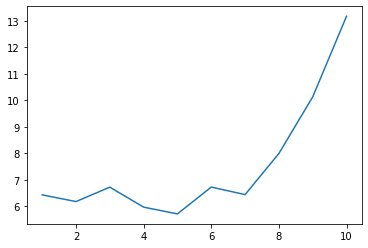

In [5]:
X = range(1,11)
Y = []
for x in X:
    Y.append(df[df.rating == x].usefulCount.mean())
fig, ax = plt.subplots()
ax.plot(X,Y);

This shows the average useful count by rating from 1 to 10. It seems that ratings of 8 and above are considered more useful than the others.

In [6]:
threshold = 33

uv = list(df.usefulCount.values)
uv.sort(reverse=True)
n = 0
while sum(uv[:n]) < threshold / 100 * df.usefulCount.sum():
    n += 1
print(str(int(n * 100 / len(df)))+'%','of the reviews received', str(threshold)+'%', 'of all the upvotes.')
print('This includes reviews with', uv[n], 'or more upvotes')

5% of the reviews received 33% of all the upvotes.
This includes reviews with 27 or more upvotes


In [7]:
df[df.usefulCount >= 27].rating.value_counts()

rating
10.0    573
9.0     232
8.0     107
1.0      92
3.0      56
7.0      50
2.0      41
5.0      40
6.0      38
4.0      28
Name: count, dtype: int64

In [8]:
threshold = 50

uv = list(df.usefulCount.values)
uv.sort(reverse=True)
n = 0
while sum(uv[:n]) < threshold / 100 * df.usefulCount.sum():
    n += 1
print(str(int(n * 100 / len(df)))+'%','of the reviews received', str(threshold)+'%', 'of all the upvotes.')
print('This includes reviews with', uv[n], 'or more upvotes')

12% of the reviews received 50% of all the upvotes.
This includes reviews with 16 or more upvotes


In [9]:
df[df.usefulCount >= 16].rating.value_counts()

rating
10.0    1203
9.0      605
8.0      291
1.0      289
7.0      127
3.0      126
5.0      122
6.0      109
2.0      108
4.0      103
Name: count, dtype: int64

In [10]:
threshold = 75

uv = list(df.usefulCount.values)
uv.sort(reverse=True)
n = 0
while sum(uv[:n]) < threshold / 100 * df.usefulCount.sum():
    n += 1
print(str(int(n * 100 / len(df)))+'%','of the reviews received', str(threshold)+'%', 'of all the upvotes.')
print('This includes reviews with', uv[n], 'or more upvotes')

31% of the reviews received 75% of all the upvotes.
This includes reviews with 8 or more upvotes


In [11]:
df[df.usefulCount >= 8].rating.value_counts()

rating
10.0    2525
9.0     1388
1.0      992
8.0      798
5.0      403
3.0      389
2.0      375
7.0      374
4.0      307
6.0      291
Name: count, dtype: int64

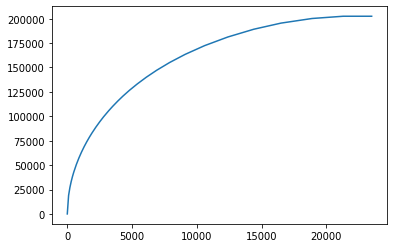

In [18]:
X = range(0,len(df),100)
Y = []
for x in X:
    Y.append(sum(uv[:x]))
fig, ax = plt.subplots()
ax.plot(X,Y);

This shows the cumulative sum of upvotes. For example, if we go 5% of the reviews in from the left on the x-axis, we would reach up to 33% of the total upvotes on the y-axis.

# feature engineering ideas

- word count
- character count
- words in all caps
- average word length
- whether words are in English (spelled correctly)
- whether it includes characters such as exclamation points, question marks, (especially repeatedly), and emoticons
- whether it mentions the brand or generic name in the review

In [21]:
df['raw_tokens'] = df.review.apply(lambda x: nltk.word_tokenize(x))

# all caps

In [24]:
def all_caps_fix(tokens_list):
    count = 0
    for token in tokens_list:
        if len(token) > 2 and token.isupper():
            count += 1
    return count

df['all_caps'] = df.raw_tokens.apply(lambda x: all_caps_fix(x))

# exclaim count

In [31]:
df['exclaim_count'] = df.raw_tokens.apply(lambda x: x.count('!'))

In [93]:
df.exclaim_count.value_counts()[:10]

exclaim_count
0    15102
1     4311
2     1952
3     1028
4      524
5      257
6      146
7       82
8       58
9       32
Name: count, dtype: int64

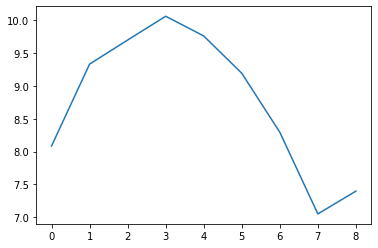

In [92]:
plot_useful('exclaim_count', high=0.995)

# question count

In [56]:
df['question_count'] = df.raw_tokens.apply(lambda x: x.count('?'))

In [57]:
df.question_count.value_counts()

question_count
0    22880
1      563
2      102
3       27
4       13
5        5
8        1
6        1
Name: count, dtype: int64

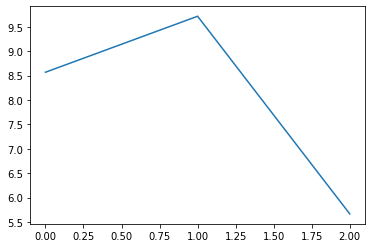

In [98]:
plot_useful('question_count', low=0.01, high=0.999)

# word count

In [60]:
df['word_count'] = df.raw_tokens.apply(lambda x: len(x))

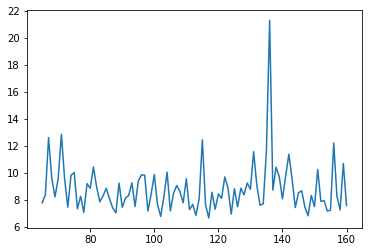

In [83]:
plot_useful('word_count')

# character count

In [67]:
df['character_count'] = df.review.apply(lambda x: len(x))

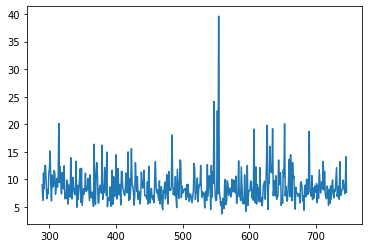

In [99]:
plot_useful('character_count')

# age reporting

In [178]:
df[df.review.str.contains('I am( only)*( just)* [1-4][0-9]')].shape

<ipython-input-178-862369aca4b1>:1: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df[df.review.str.contains('I am( only)*( just)* [1-4][0-9]')].shape


(2046, 22)

In [156]:
df.review.loc[18]

'"Had sex on the 7th of August. Took Plan B about 23 hours after from the intercourse. Have not gotten my period yet because I am not supposed to be due until the 20th of August but a major side effect that I have been experiencing is a MAJOR amount of tiredness and exhaustion! When I got home from work the day after I took the pill, I went upstairs around 9pm to sleep and woke up the next day around 1pm. I wake up extremely exhausted and my feet start to get tired as well. Also I barely ever hungry anymore... I am 18 years old so this is very unusual for a teen... Hopefully my period comes soon."'

In [122]:
df[
    (df.review.str.contains('years of age')) | \
    (df.review.str.contains('years old')) | \
    (df.review.str.contains('year-old')) | \
    (df.review.str.contains('years-old'))
].shape

(782, 21)

In [127]:
for ind in df[df.review.str.contains('I am 16 ')].index:
    display(df.review.loc[ind])

'"I am 16 and  I have been on Loestrin 24 for about a week and half. The day I got them (and started taking them) was a day after I stopped my period and two days ago I started my period it is like a normal. I do not think I have gained weight due to me being sick and therefore do not eat as much as I normally do but I did not lose weight like I normally do when I am sick. I have been getting cramps which I do not normally get except the first one or two days of my period. I have been really depressed and I am not a depressed person. I mean I was crying over the stupidest things like my mom not cooking dinner when I was not even hungry. I am going to talk to my doctor tomorrow."'

'"I am 16 years old and had unprotected sex with my boyfriend about a week ago. It was not planned and it just went too far too fast. I took the morning after pill about 2 hours after and experienced an upset stomach a few hours after taking it, resulting in vomiting. I freaked out thinking that the pill was not absorbed in my bloodstream but today I just got my period (thank God) I recommend this pill but not as a regular birth control!! Do not be like me and use a condom please!"'

'"I am 16 and have been on this for almost a year now. I like this medication because for me it has done a great job on easing my headaches and nausea. I still get some once in a while but it is not as bad as before. I have not had any real problems with my mood but I do see that I cry more often and sometimes get a little depressed, but I am able to blow it off. The only real criticism I have about this medication is that when I started on my period again it was regular then it stopped. COMPLETELY! but I was like what t?!? I would spot but at random times. For the year I have been using it I can say I have only got my period maybe twice. Very hard to know if you are preg without a period."'

'"I am 16 and I have been taking this birth control for about 5 months and at first I loved it, I had shorter/ lighter periods and my breasts got bigger but here lately I have been having a lot of problems with it. I have been having really bad headaches. I am really moody, get angry easy, I cry for no reason, lower back has been hurting, bad cramps, gaining weight that I cannot seem to lose, and me and my boyfriend fight all the time (which we never seemed to do before) and I think if I do not get off it soon then I would lose him. "'

'"I am 16 and I took Ortho Tri-Cyclen Lo because I suffer from hormonal severe acne. I have had horrible acne since 7th grade. On the issue of acne, while I was on the pill, after 3 months my skin was clear. In the last remaining week, I got sick everyday. Then I was finished with my pill because it cured my acne. Suddenly a couple months later, my acne returned again. I just started taking my pill again. I am feeling the nausea and headaches. I take the pill at night, so I do not feel it when I go to bed. Unfortunately the following morning I feel intense nausea. If you are looking to treat acne this is the pill. Just the side effects can be a pain."'

'"Well, to start off I am 16 years old and I have very strange/heavy periods so this birth control pill was prescribed to me by my doctor. So far I am down to my last 4 pills of the first month and I do not have any negative effects from it. My acne before this pill was a bit severe, now its starting to clear up, a lot actually, I have not had my period yet but I am assured its on its way, I am not moody, my cup size went from a C to a D, and I am almost sure I have actually lost weight! Also, my appetite is not as strong as it used to be which is strange, I do not eat exactly healthy but I do consume food in smaller portions and I work out a couple of times a week. I am just very pleased with it right now, girls you should definitely try it."'

'"I love Nexplanon. I started it about 4 months ago and it has not been at all terrible for me. I have been having lighter periods that last for about a week and a half. It is not that big of a deal because they are so light. I also do not get cramping at the level I used to get it. I am hoping my period will stop all together, but either way it is still so much lighter than what I used to have before. I have not gained any weight except maybe a pound or two but that is because I already had a weakness for sweets. I also did not have any acne problems. I am 16 and my skin has been as clear as a baby\'s bottom. I think Nexplanon had to do with it because my problem acne areas have not had any breakouts and I love it."'

'"I am 16 years old and have been taking Yaz for four months now to lighten my period and help with PMS. It has really helped me. It took my body the first few months to get used to it (I had mild breakouts, mood swings, tender breasts and little if no change in period flow or PMS), but after about two months it has worked quite well. My periods are lighter, I rarely get cramps and when I do they are very mild and it has also made my skin softer and clearer. I do not get as moody or as emotional either. I would say the only down fall is that I crave food a lot, but that might have nothing to do with Yaz, and besides I do not think my weight has changed more than a pound. Good experience so far."'

'"This is my first birth control pill I have ever been on so I do not have anything to compare it to but I am 16 years old and have 11 day periods which are extremely heavy with terrible cramps, fatigue, and headaches. My gyn put me on this and everything was great for the first 3 weeks. I never had any breakthrough bleeding. I did have some slight cramps for the first week but they were nothing compared to what I have been on. I am on the first day of the placebo and so far no bleeding but I do have awful cramps again which I thought the pill was supposed to take care of this. If this is the way my period is going to be every month I might ask my doctor about Seasonique so I only have to deal with this once every 3 months."'

'"I recently started taking this birth control 4 days ago & so far, so good! I was put on it to regulate my periods because they were really weird from being on the Depo shot. I have been a little bloated and my body does seem a tad bit sore every other day though, but I think that is just my body getting used to it! I am 16 years old and I do have mild-severe acne from a hormonal imbalance, so hopefully with proper dieting & this medication it will clear up in no time fingers crossed."'

'"Just got the procedure done about 30 minutes ago. The most painful part was getting my cervix dilated and I have cramps on and off. I felt very light headed after the procedure was done and the doc said I was very flush. I am 16 and have never been pregnant so my cervix had never been dilated, I think that is what sent me into a bit of a shock. So far so good though. I would recommend getting it done if you can tolerate a moderate amount of pain for a while."'

'"I am 16 years old and started the pill 4-5 months ago. Was not sexually active on the pill. Took some time but It cleared my skin up wonderfully. Although, I have gained a significant amount of weight. Grew out of mostly all my jeans. I gained about 10 pounds so I am switching to another birth control. Not positive if this all caused by the pill, but weight has never been a problem for me. Did not notice any mood changes. My periods were really light. Just not happy about the weight gain..."'

'"I am 16 years old and the first couple of days after I started taking Tri-Sprintec, I had terrible nausea. Right now, I am on my tenth day of taking it and the nausea got a little better, but my moodiness is driving me and everyone around me crazy. I feel really irritated all the time and I feel like I can break down crying any moment. I also started my period at least two weeks early. Hopefully, these symptoms will settle down after I have been on the pill for a month."'

'"I am 16 Years Old. I have been taking Seasonique since I was 14 and all I can say is that Seasonique is a GREAT Birth control. I have only had one side effect and that is a Little Cramps but Nothing Big. I Love it because I have Never got pregnant on it And I Suffer from body and Face acne and Seasonique did a GREAT Job on Clearing that up. So now I have Beautiful skin. Seasonique is Very Good. My Skin Cleared up the first week I took it!"'

'"I am 16 and I was diagnosed with Polycystic Ovarian Syndrome about 2 weeks ago. I was basically not getting my period. My pediatrician recommended Beyaz to control my Hormone level and some other things. I was skeptical about taking Birth control because of side effects such as depression and weight gain. I tend to be a very happy and energetic person and honestly I was scared to lose that, I was VERY SURPRISED THOUGH, Beyaz has not changed my mood at all, I have not gained weight and overall I feel fine! Except for its made me TIRED. I work around that though and its no big deal. As for acne, Beyaz controls it amazingly. So far THANK YOU BEYAZ! You are really helping my future."'

'"I know its really scary thinking your pregnant when you know your not ready .. I am 16 my experience was terrifying to me . It happened when we noticed the condom broke, he did not fully ejaculate in me but some slipped in as he pulled and that is when we noticed the condom was ripped. 4 hours later I was able to take a the plan B no side effects occurred. It was on Friday 13th , then exactly one day before one week passed I got my period ! Do not stress . Taking the the pill works the sooner the better ."'

'"took plan b 17 hours after an accident... still do not know results because I have not gotten/am not due for my period. the side effects were pretty bad (stomach/back cramps, fatigue, nauseous) and is pretty pricey (50$) I got a 10$ off coupon online, still came out to 45$... I am 16 so this sucked to have to buy and take"'

'"I am 16 and this was my first method of birth control. I was not good at taking pills so I chose this. In the first couple weeks my breasts felt tender. I only felt nauseous one time. I have had some headaches but nothing too bad. I also got more acne but now that I am at the end of 3 months it seems like its gone away. I also fear that it will make me gain weight because I have gained 2-4 pounds since then. But I think my breasts got bigger."'

'"I started Sprintec in September so I am going on my 3rd month. I have mixed feelings about it. I do not receive bad cramps anymore and my acne does not come around when my period is here. I do not like that I get depressed or sad and my last period lasted 17 days and my doctor told me to stop for some days then start again and she told me to not take the placebos. Overall I would recommend, I am 16 which means I might be a different candidate."'

'"I am 16 years old (17 in 5 days). My friend and I were making out, which led to a bj, which then led to unprotected sex. It was a heat of the moment thing. It did not hit me until the next morning that I needed to get something to stop me from being eligible to star in that TV show "16 and Pregnant". I had unprotected sex on August 3rd and took the pill on August 4th (19 hours later). I did not experience any side effects, which honestly made me worry that the pill was not working.  This morning, I woke up with my period and I could not be happier. It is heavier than usual and 9 days late but better late than never, am I right ladies?"'

'"I am 16 and went on the pill because I had long heavy periods with cramping. I have only been on the pill for a little over a month but it helped my period so much! I also had no cramping at all! I was kind of scared to start taking it after reading all the negative reviews but I am so glad I did. I have no bad side effects at all. I actually lost three pounds already without even trying!"'

'"I am 16 and have taken this pill for seven months. Pros: increase sex drive, little acne, not pregnant cons: slightly moody, period twice a month, bad cramping"'

'"I am 16 and apparently the youngest to get Mirena from all the reviews I have read. I only got it inserted a few days ago. I have never had children, nor have I ever been pregnant. I have also not had much sexual experience, but the procedure was quite quick and really was not that painful. I do not consider my pain tolerance very high but the pain was very bearable. I got it inserted while on my period. During my usual menstruation I get horrible cramps that will even because me to vomit, but during the procedure the pain was not even close to that. I felt pretty much normal walking or of the building, no cramping. I even went horseback riding for 2 hours right after the procedure! I immediately noticed a difference in my period. Love it!"'

'"absolutely loved this pill the first 5 months of taking it, light period, only 2-3 days. no cramps. Its very effective - pregnancy wise. but its been a year now. I have not gotten my period since August 15 and it is now November 11th. Sure its nice but it is very unhealthy for the body. I am not pregnant if that is what you were thinking, the pill just does not give me periods. I have had terrible tension headaches all year, and all the sudden breaking out all in my T zone of the face. Blind pimples. & boils under my armpits. Along with nausea and drowsiness. I am 16 and do not want to have to deal w all these side effects! not too mention the pill makes me feel sad and crazy sometimes. I definitely do not recommend it."'

'"I just got Skyla yesterday, and I took 800 mg Motrin before and after. The insertion was the most painful experience I have ever experienced. (But keep in mind I am 16 and have had no kids lol, also it is different for everyone I guess) after I got it inserted which only took about 3-5 minutes I had the worst cramps ever, my knees and my back also started hurting. I cried because the cramps were so painful. But today (which is the day after) I am not feeling any cramps or hurting any where. I do not even feel it now."'

'"Before I started using Yaz I was very scared because of all the bad things people had said. After finishing my first pack of Yaz and I noticed a lot of spotting and some odd bleeding now and then. I am 16 years old and had been switching pills for a while now because none of them seemed to suit me. I use Yaz for period pains ONLY and have noticed a huge improvement in my cramps, there still is some mild cramps but not near as bad as they were before. Already my breasts have gotten bigger which I do not really mind because I was near the smallest bra size you can get. My mood is completely fine. My skin has never been Acne prone but it has not broke out at all. I have not noticed any side effects. I love this pill."'

'"I am 16 years old, and I have been on the shot since July 2013. I have not had any of the side effects like having unusual cramps, headaches, or ance. The only problem that I have is I spot on and off for about 2-3 weeks right before I am supposed to get my next shot."'

'"I am 16 and have been on this birth control for about a year and few months now. The first few months, had weird brown discharge and I was really moody, boobs were really sore, and they grew. I have gained about 15 pounds since being on birth control.. I was put on it for regulating my period but have had my first boyfriend and I have been sexually active. My acne was not bad to begin with but now its starting to act up, I still get moody.. And sometimes my periods come three days late (its exactly 3 days every time) but it ends up coming which worried me before. But it does its job in regulating and preventing pregnancy."'

'"I am 16 and have had about a 4 year history with ovarian cysts. I had Skyla placed last month during a light period. 30 minutes before the procedure, I took 800 mg ibuprofen and 2 Midol. I did experience pain during the procedure but only for a moment during the placement prep to place the IUD. Immediately, I felt sore. An hour later, I started feeling irritable but it passed after 30 mins. 2 days after insertion, I started experiencing severe cramps and it continued for the rest of the month every 2-3 days. For the past week and a half, I have been having extremely painful cramps. Last week I went back to my gyno for cramps and I got an internal ultrasound. It showed a large cyst on my ovary but the doc basically said it was normal. He prescribed me 550 mg naproxen for the cramping. But overall, Skyla has been effective."'

'"I am 16 years old with no kids. The insert of the Mirena was very painful, and I mean so painful that I teared up and felt very dizzy after. I have used birth control pills in the past for heavy bleeding and cramping but I got break through bleeding. The first day of getting it inserted was probably the worst day, now I am just spotting! But I do recommend this device to other teens/women who have heavy periods!"'

'"I have been taking Yaz for 4 months now, I am 16 years old. Few complaints, at the beginning this pill caused me horrible nausea and breast pain but that could be due to changing to Yasmin from Microgynon 30. Also I experienced spells of depressive moods which have now cleared up but I often experience mood swings! On a positive note my skin has cleared up massively and have maintained if not lost weight, great pill."'

'"I am 16 years old and I was put on Sprintec to regulate my periods. The first month of taking it I did not have any side effects besides that I was hungry and gained about 5 pounds. The second month I started to become very moody. I kept taking the pill and now I am experiencing anxiety and depression. I am very emotional and worried about everything.  I almost lost my boyfriend because of it and I am going to the Doctor about my anxiety and depression. "'

'"I am 16 and I have been on the depo shot 7 months so yes I have only had 3, \r\nI received my first in April, I was actually quite scared so my friend came with me but I did not even know the nurse had finished then I received my second one two days late of when I was meant to, it was meant to be the Wednesday in July however I forgot about it and received it on the Friday 17th July for these I had no bleeding at all then in September I had this brown looking mark in My underwear and realised it is dry blood telling me I am due my next injection soon. the nurse told me this could carry on a little throughout protection of this one and it is normal!  I had my 3rd one yesterday  9/10/15 and I was told this one may bleed but it will stop soon."'

'"I have been on Loestrin 24 for around 5 months and I am overall very happy with it. I am 16 and sexually active. The first three months were bad in terms of side effects. Lots of nausea, acne, spotting and cramping. But from the get go I went from heavy, long periods to very short light periods. For the past two months I have had just spotting for around 3 days, not exactly in correspondence with my brown pills but close enough. I no longer get bloated on my period, I do still have acne around my time of the month but that can be attributed to my negligence of going to the dermatologist in half a year. It worries me that some people get no period at all because pregnancy scares are definitely not my favorite. But now I feel safe and satisfied."'

'"I am 16 and just finished my first pack. I am on it because I have had the worst experience with periods ever since I was 13. Periods lasting 9-16 days, heaviest bleeding I have ever seen, and cramps so bad I would not be able to go to school. Since I started, I noticed a few changes in the first month- My face is more clear, I feel refreshed, and my breasts grew. Not sure if that is normal, but I am not going to complain. But I have also got some weird experiences too- WILD mood swings, I have spotted once, but that is to be expected for the first few months. I just got to the 1st in-active pill and do not know what to expect. I hope my period lasts for how long most people are saying. Wish me luck."'

In [ ]:
df['review_lower'] = df['review'].str.lower()

In [ ]:
# make list of all tweet texts
all_reviews = df.review.to_list()

In [ ]:
# make lemmatizer
lemmatizer = WordNetLemmatizer()

In [32]:
# obtain the standard list of stopwords
nltk.download('stopwords', quiet=True)
# start our own list of stopwords with these words
stop_list = stopwords.words('english')
# add to this list some twitter-specific terms
stop_list.extend(['sxsw', 'link', 'rt'])
# add punctuation characters
for char in string.punctuation:
    stop_list.append(char)
# add empty string
stop_list.extend(['', 'ha', 'wa'])

In [ ]:
stop_list = []

In [ ]:
def make_ngrams(word_list, n):
    length = len(word_list)
    if length < n:
        return None
    else:
        ngram_list = []
        for i in range(length - n + 1):
            ngram = ''
            for j in range(i, i+n):
                if j > i:
                    ngram += ' '
                ngram += word_list[j]
            ngram_list.append(ngram)
        return ngram_list

In [ ]:
# a function that takes a list of reviews and 1) tokenizes them, 2) lemmatizes them, and 3) removes stopwords
# this function returns a one-dimensional list of tokens
def make_tokens(reviews):
    # make list of tokens
    tokens = nltk.word_tokenize(','.join(reviews))
    # lemmatize tokens
    tokens_lemmatized = [lemmatizer.lemmatize(word) for word in tokens]
    # stop tokens
    tokens_stopped = [word for word in tokens_lemmatized if \
                      word not in stop_list]
    return tokens_stopped

In [ ]:
tokens_pos = make_tokens(df[(df.condition == 'Birth Control') & (df.usefulCount > 16)].review_lower.to_list())
tokens_neg = make_tokens(df[(df.condition == 'Birth Control') & (df.usefulCount == 0)].review_lower.to_list())

In [ ]:
plot_wordcloud(make_wordcloud(tokens_neg))

In [ ]:
df['word_count'] = df.review.apply(lambda x: len(x.split()))

In [ ]:
df['char_count'] = df.review.apply(lambda x: len(x))

In [ ]:
df['logUsefulCount'] = df.usefulCount.apply(lambda x: np.log(x) if x > 0 else 0)

In [ ]:
'!' in df.loc[5].review

# rudimentary word cloud maker

In [ ]:
df_bookmark_3 = df.copy()

In [ ]:
df = df[df.condition == 'Birth Control']

def sentiment_fix(rating):
    if rating > 8:
        return 1
    elif rating < 2:
        return 0
    else:
        return None

df['sentiment'] = df.rating.apply(lambda x: sentiment_fix(x))

df_pos = df[df.sentiment == 1]

df_neg = df[df.sentiment == 0]

In [ ]:
# make list of all reviews
reviews_pos = df_pos.review_lower.to_list()
reviews_neg = df_neg.review_lower.to_list()

In [ ]:
# # make tokenizer
# tokenizer = TweetTokenizer(
#     preserve_case=False,
#     strip_handles=True
# )

# create list of tokens from data set
tokens_pos = word_tokenize(','.join(reviews_pos))
tokens_neg = word_tokenize(','.join(reviews_neg))


# tokens = [word for word in tokens]

In [ ]:
# make lemmatizer
lemmatizer = WordNetLemmatizer()

# lemmatize the list of words
tokens_lemmatized_pos = [lemmatizer.lemmatize(word) for word in tokens_pos]
tokens_lemmatized_neg = [lemmatizer.lemmatize(word) for word in tokens_neg]

In [ ]:
# show the most frequently occurring tokens
FreqDist(tokens_lemmatized_pos).most_common(25)

In [ ]:
# show the most frequently occurring tokens
FreqDist(tokens_lemmatized_neg).most_common(25)

In [ ]:
negatives = ['no', 'not', "don't", "aren't", "couldn't", "didn't", "doesn't", "hadn't", "hasn't", "haven't", \
             "isn't", "wasn't", "weren't", "won't", "wouldn't"]

In [ ]:
# obtain the standard list of stopwords
nltk.download('stopwords', quiet=True)
# start our own list of stopwords with these words
stop_list = [word for word in stopwords.words('english') if word not in negatives]
# add punctuation characters
for char in string.punctuation:
    stop_list.append(char)
# add empty string
stop_list.extend(['', 'ha', 'wa'])

In [ ]:
stop_list

In [ ]:
# make stopped list of tokens
tokens_stopped_pos = [word for word in tokens_lemmatized_pos if word not in stop_list]
tokens_stopped_neg = [word for word in tokens_lemmatized_neg if word not in stop_list]

In [ ]:
# show the most frequently occurring tokens
FreqDist(tokens_stopped_pos).most_common(25)

In [ ]:
# show the most frequently occurring tokens
FreqDist(tokens_stopped_neg).most_common(25)

In [ ]:
# word cloud of stopped words
plot_wordcloud(make_wordcloud(tokens_stopped_pos))

In [ ]:
# word cloud of stopped words
plot_wordcloud(make_wordcloud(tokens_stopped_neg, colormap='Reds'))

In [ ]:
df.groupby('rating').usefulCount.median()

In [ ]:
len(df)

# end